In [6]:
# comprehensive calculator for EVs, PHEVs, HEVs and ICEs (internal combustion engine vehicles)

def estimate_electric_range_km(battery_size_kwh: float, electric_efficiency: float) -> float:
    """Return the electric range of a PHEV in km
    
    inputs:
        battery_size_kwh: the size of the usable battery in kWh
        electric_fuel_efficiency: the fuel efficiency of the vehicle when running on electric power, in kwh/100km
        
    return the electric range in km
    """
    
    return battery_size_kwh / electric_efficiency * 100


def estimate_fuel_consumption_phev(distance: float, battery_size_kwh: float, electric_efficiency: float, petrol_fuel_efficiency: float,
                                   return_fuel_consumed=False) -> float:
    """Estimate fuel consumption for a PHEV, given its range, electric range, and fuel efficiencies
    
    inputs:
        range: the total distance of the vehicle travelled in km
        battery_size_kwh: the size of the usable battery in kWh
        petrol_fuel_efficiency: the fuel efficiency of the vehicle when running on petrol
        electric_fuel_efficiency: the fuel efficiency of the vehicle when running on electric power, in kwh/100km
        
    
    return the estimated units in L/100km
    """
    
    electric_range_km = estimate_electric_range_km(battery_size_kwh, electric_efficiency)
    
    
    if electric_range_km >= distance:
        return 0
    
    consumed_petrol = (distance - electric_range_km) * petrol_fuel_efficiency / 100
    
    if return_fuel_consumed:
        return consumed_petrol
    
    estimated_fuel_efficiency = consumed_petrol / distance * 100
    
    return estimated_fuel_efficiency


def estimate_fuel_consumption_phev_hybrid_mode(distance: float, 
                                               battery_size_kwh: float, 
                                               petrol_fuel_efficiency: float, 
                                               hybrid_electric_eff: float, 
                                               hybrid_fuel_efficiency: float, 
                                               return_fuel_consumed=False
                                               ) -> float:
    
    hybrid_range_km = estimate_electric_range_km(battery_size_kwh, hybrid_electric_eff)
    
    if hybrid_range_km >= distance:
        hybrid_mode_consumed_petrol = distance * hybrid_fuel_efficiency / 100

        if return_fuel_consumed:
            return hybrid_mode_consumed_petrol
        
        estimated_fuel_efficiency = hybrid_mode_consumed_petrol / distance * 100
        return estimated_fuel_efficiency
    
    hybrid_mode_consumed_petrol = hybrid_range_km * hybrid_fuel_efficiency / 100
    depleted_mode_consumed_petrol = (distance - hybrid_range_km) * petrol_fuel_efficiency / 100
    
    if return_fuel_consumed:
        return hybrid_mode_consumed_petrol + depleted_mode_consumed_petrol
    
    estimated_fuel_efficiency = (hybrid_mode_consumed_petrol + depleted_mode_consumed_petrol) / distance * 100
    return estimated_fuel_efficiency
    
    
def estimate_petrol_cost(distance: float, petrol_cost_per_litre: float, battery_size_kwh: float, electric_efficiency: float, petrol_fuel_efficiency: float) -> float:
    fuel_consumed = estimate_fuel_consumption_phev(distance, battery_size_kwh, electric_efficiency, petrol_fuel_efficiency, return_fuel_consumed=True)
    cost = fuel_consumed * petrol_cost_per_litre
    return cost


def estimate_total_cost(distance: float, 
                        petrol_cost_per_litre: float, 
                        battery_size_kwh: float, electric_efficiency: float, 
                        petrol_fuel_efficiency: float, 
                        cost_per_kwh: float,
                        ev_road_tax_rate: float,
                        parking_fee: float = 0,
                        exclude_road_tax: bool = False,
                        solar_ratio: float = 0,
                        electric_only=False,
                        recharge_times=1) -> float:
    """Estimate the total cost of a trip in a PHEV
    """
    
    # a cost base of using electricity only, all or partially solar generated/free
    E_COST = distance / 100 * electric_efficiency * cost_per_kwh * (1-solar_ratio)
    if electric_only:
        if exclude_road_tax:
            return E_COST + parking_fee
        else:
            return E_COST + ev_road_tax_rate * distance + parking_fee

    electric_range_km = estimate_electric_range_km(battery_size_kwh, electric_efficiency) * recharge_times
    
    if electric_range_km >= distance:
        # calculate electricity cost
        # print(f'Electricity used: {distance / 100 * electric_efficiency}, cost: {distance / 100 * electric_efficiency * cost_per_kwh}')
        cost = distance / 100 * electric_efficiency * cost_per_kwh * (1-solar_ratio)
    
    else:
        # calculate petrol cost
        fuel_consumed = estimate_fuel_consumption_phev(distance, battery_size_kwh, electric_efficiency, petrol_fuel_efficiency, return_fuel_consumed=True)
        cost = fuel_consumed * petrol_cost_per_litre
        
        # calculate electricity cost
        cost += electric_range_km / 100 * electric_efficiency * cost_per_kwh * (1-solar_ratio)
    
    if exclude_road_tax:
        return cost + parking_fee
    
    return cost + ev_road_tax_rate * distance + parking_fee


vehicle_information = {'battery_size_kwh': 10.2, 'electric_efficiency': 20, 'petrol_fuel_efficiency': 6.5}
economic_factors = {'cost_per_kwh': 0.2, 'petrol_cost_per_litre': 2.2, 'ev_road_tax_rate': 0.023}


distance = 100


def generate_report(distance, vehicle_information, economic_factors): 
    fuel_price_AUD = economic_factors['petrol_cost_per_litre']

    electric_range = estimate_electric_range_km(vehicle_information['battery_size_kwh'], vehicle_information['electric_efficiency'])


    fuel_economy = estimate_fuel_consumption_phev(distance, **vehicle_information)
    fuel_consumed = estimate_fuel_consumption_phev(distance, **vehicle_information, return_fuel_consumed=True)
    cost = estimate_petrol_cost(distance, fuel_price_AUD, **vehicle_information)


    parking_fee = 0
    total_cost = estimate_total_cost(distance, **vehicle_information, **economic_factors, parking_fee=parking_fee)
    total_cost_without_tax = estimate_total_cost(distance, **vehicle_information, **economic_factors, parking_fee=parking_fee, exclude_road_tax=True)
    total_cost_on_solar = estimate_total_cost(distance, **vehicle_information, **economic_factors, parking_fee=parking_fee, solar_ratio=1)
    on_solar_without_tax = estimate_total_cost(distance, **vehicle_information, **economic_factors, parking_fee=parking_fee, solar_ratio=1, exclude_road_tax=True)
    electric_only = estimate_total_cost(distance, **vehicle_information, **economic_factors, parking_fee=parking_fee, electric_only=True)
    electric_only_without_tax = estimate_total_cost(distance, **vehicle_information, **economic_factors, parking_fee=parking_fee, electric_only=True, exclude_road_tax=True)

    solar_factor = 1
    e_cost_with_solar = estimate_total_cost(distance, **vehicle_information, **economic_factors, parking_fee=parking_fee, solar_ratio=solar_factor, electric_only=True)
    e_cost_with_solar_without_tax = estimate_total_cost(distance, **vehicle_information, **economic_factors, parking_fee=parking_fee, solar_ratio=solar_factor, electric_only=True, exclude_road_tax=True)

    on_electric_range =  distance if electric_range > distance else electric_range
    on_petrol_range = distance - on_electric_range if distance >= electric_range else 0

    print(f'Economic Factors: {economic_factors}')
    print(f'Car Factors: {vehicle_information}')
    print('---------------')
    print(f'The Distance Entered: {distance} km, Electric Range: {on_electric_range:.2f} km, Petrol Range: {on_petrol_range:.2f} km')
    print(f'Fuel economy estimated: {fuel_economy:.2f}L/100km, Petrol Cost estimated: ${cost:.2f}, Fuel Consumed: {fuel_consumed:.2f}L')
    print('---------------')
    print(f'Cost with electicity and road tax: ${total_cost:.2f}')
    print(f'Zero Tax Equivalence: ${total_cost_without_tax:.2f}')
    print('---------------')
    print(f'Cost with electicity and road tax, but on an electric range covered by solar: ${total_cost_on_solar:.2f}')
    print(f'Zero Tax Equivalence: ${on_solar_without_tax:.2f}')
    print('---------------')
    print(f'Cost with assumed recharge with electricity (no solar): ${electric_only:.2f}')
    print(f'Zero Tax Equivalence: ${electric_only_without_tax:.2f}')
    print('---------------')
    print(f'Cost with assumed recharge with electricity, but on a solar (free) factor of {solar_factor}: ${e_cost_with_solar:.2f}')
    print(f'Zero Tax Equivalence: ${e_cost_with_solar_without_tax:.2f}')
    
generate_report(distance, vehicle_information, economic_factors)
    

Economic Factors: {'cost_per_kwh': 0.2, 'petrol_cost_per_litre': 2.2, 'ev_road_tax_rate': 0.023}
Car Factors: {'battery_size_kwh': 10.2, 'electric_efficiency': 20, 'petrol_fuel_efficiency': 6.5}
---------------
The Distance Entered: 100 km, Electric Range: 51.00 km, Petrol Range: 49.00 km
Fuel economy estimated: 3.19L/100km, Petrol Cost estimated: $7.01, Fuel Consumed: 3.19L
---------------
Cost with electicity and road tax: $11.35
Zero Tax Equivalence: $9.05
---------------
Cost with electicity and road tax, but on an electric range covered by solar: $9.31
Zero Tax Equivalence: $7.01
---------------
Cost with assumed recharge with electricity (no solar): $6.30
Zero Tax Equivalence: $4.00
---------------
Cost with assumed recharge with electricity, but on a solar (free) factor of 1: $2.30
Zero Tax Equivalence: $0.00


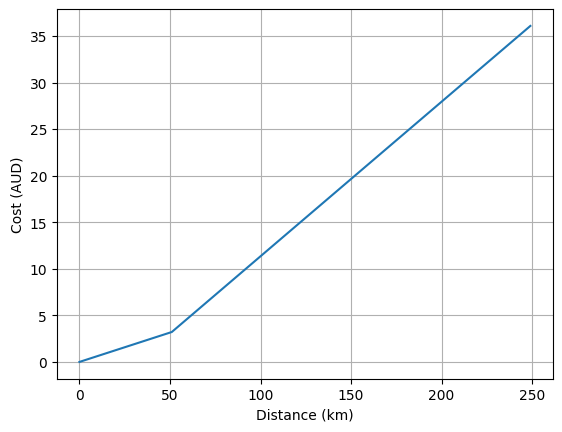

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def plot_cost(distance: float, **kwargs):
    x = np.arange(0, distance, 1)
    y = [estimate_total_cost(i, **kwargs) for i in x]
    plt.plot(x, y)
    # labels 
    plt.xlabel('Distance (km)')
    plt.ylabel('Cost (AUD)')
    plt.grid()
    plt.show()
    
def plot_fuel_economy(distance: float, **kwargs):
    x = np.arange(0, distance, 1)
    y = [estimate_fuel_consumption_phev(i, **kwargs) for i in x]
    plt.plot(x, y)
    # labels
    plt.xlabel('Distance (km)')
    plt.ylabel('Fuel Economy (L/100km)')
    plt.grid()
    plt.show()
    
def plot_fuel_economy_hybrid(distance: float, **kwargs):
    x = np.arange(0, distance, 1)
    y = [estimate_fuel_consumption_phev_hybrid_mode(i, **kwargs) for i in x]
    plt.plot(x, y)
    # labels
    plt.xlabel('Distance (km)')
    plt.ylabel('Fuel Economy (L/100km)')
    plt.grid()
    plt.show()
    
plot_cost(250, **vehicle_information, **economic_factors, parking_fee=0, solar_ratio=0, electric_only=False)

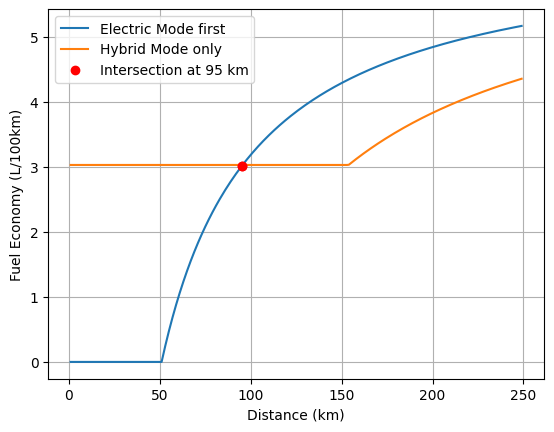

In [10]:
distance = 250

x1 = np.arange(1, distance, 1)
y1 = [estimate_fuel_consumption_phev(i, **vehicle_information) for i in x1]
plt.plot(x1, y1, label='Electric Mode first')
# labels
plt.xlabel('Distance (km)')
plt.ylabel('Fuel Economy (L/100km)')

# label line for electric range
# electric_range = estimate_electric_range_km(vehicle_information['battery_size_kwh'], vehicle_information['electric_efficiency'])
# plt.axvline(electric_range, color='r', linestyle='--', label='Electric Range')


profile1 = {'hybrid_electric_eff': 4.3, 'hybrid_fuel_efficiency': 3.36}
profile2 = {'hybrid_electric_eff': 6.5, 'hybrid_fuel_efficiency': 3.03}
profile3 = {'hybrid_electric_eff': 8.6, 'hybrid_fuel_efficiency': 2.7}
profile4 = {'hybrid_electric_eff': 10.8, 'hybrid_fuel_efficiency': 2.4}


x2 = np.arange(1, distance, 1)
y2 = [estimate_fuel_consumption_phev_hybrid_mode(i, battery_size_kwh=10, 
                                                 petrol_fuel_efficiency=6.5, 
                                                **profile2) for i in x2]
plt.plot(x2, y2, label='Hybrid Mode only')
# labels
plt.xlabel('Distance (km)')
plt.ylabel('Fuel Economy (L/100km)')

# get the intersection point
import numpy as np

intersection = np.argwhere(np.diff(np.sign(np.array(y1) - np.array(y2)))).flatten()
plt.plot(np.array(x1)[intersection], np.array(y1)[intersection], 'ro')

# show the intersection point on plot 
if len(intersection) > 0:
    plt.plot(np.array(x1)[intersection], np.array(y1)[intersection], 'ro', label=f'Intersection at {np.array(x1)[intersection][0]} km')

plt.legend()
plt.grid()
plt.show()


In [50]:
generate_report(250, vehicle_information, economic_factors)

Economic Factors: {'cost_per_kwh': 0.2, 'petrol_cost_per_litre': 2.2, 'ev_road_tax_rate': 0.023}
Car Factors: {'battery_size_kwh': 9.8, 'electric_efficiency': 20, 'petrol_fuel_efficiency': 6.5}
---------------
The Distance Entered: 250 km, Electric Range: 49.00 km, Petrol Range: 201.00 km
Fuel economy estimated: 5.23L/100km, Petrol Cost estimated: $28.74, Fuel Consumed: 13.06L
---------------
Cost with electicity and road tax: $36.45
Zero Tax Equivalence: $30.70
---------------
Cost with electicity and road tax, but on an electric range covered by solar: $34.49
Zero Tax Equivalence: $28.74
---------------
Cost with assumed recharge with electricity (no solar): $15.75
Zero Tax Equivalence: $10.00
---------------
Cost with assumed recharge with electricity, but on a solar (free) factor of 1: $5.75
Zero Tax Equivalence: $0.00


The answer is simple: 
- drive short distances and recharge as often as you can. 
- always find a parking spot with a charging station, take every opportunity to recharge even when outside. 
- intelligent hybrid mode may or may not improve fuel economy on trips between 100 - 150 km. 